# All-Purpose Notebook for Working with WRF-ELEC Simulations of LEE Field Campaign

### Importning necessary libraries

In [1]:
import netCDF4
from netCDF4 import Dataset
import matplotlib.pyplot as plt
from matplotlib.cm import get_cmap
from matplotlib import animation
from mpl_toolkits.basemap import Basemap
import numpy as np
import wrf
from wrf import to_np, getvar, smooth2d, get_basemap, latlon_coords
import xarray as xr
import metpy.calc as mpcalc
from metpy.plots import SkewT
from metpy.units import units

## Loading in wrfout Files - *Must be run prior to any other sections below*

In [2]:
# Gather all necessary variables from user
iop = int(input("Enter IOP #: "))
hourstart = int(input("Enter start hour: "))
daystart = int(input("Enter start day: "))
monthstart = int(input("Enter start month: "))
yearstart = int(input("Enter start year: "))
faketotalhours = int(input("Enter total run hours: "))
domain = int(input("Enter domain # to be loaded in: "))
varneeded = input("Enter variable wanted (ELECZ for E-Field, 0 to load in wrfoutfiles without a specified variable): ")

# wrfouts contain a file from when the run was initiated which adds 1 to the total hours,
# for example for a 48 hour run from 00z to 00z 2 days later, there are 49 total files as
# there is the 00z file for the first day and 2 days later, basically this adding 1 accounts
# for that
totalhours = faketotalhours + 1

Enter IOP #:  2
Enter start hour:  0
Enter start day:  18
Enter start month:  11
Enter start year:  2022
Enter total run hours:  48
Enter domain # to be loaded in:  2
Enter variable wanted (ELECZ for E-Field, 0 to load in wrfoutfiles without a specified variable):  ELECZ


In [3]:
hourcurrent = int(hourstart)
daycurrent = int(daystart)
wrfin = {}
vargot = {}
#Load in wrfout files
for i in range(totalhours):
    if hourcurrent < 10:
        houruse = f"0{hourcurrent}"
    if 10 <= hourcurrent < 24:
        houruse = hourcurrent
    if hourcurrent == 24:
        houruse = "00"
        daycurrent = daycurrent + 1
        hourcurrent = 0
    if daycurrent < 10:
        dayuse = f"0{daycurrent}"
    if daycurrent >= 10:
        dayuse = daycurrent
    #Open NetCDF
    wrfin[int(i)] = Dataset(f"IOP{iop}\\wrfout_d0{domain}_{yearstart}-{monthstart}-{dayuse}_{houruse}-00-00")
    print("Loaded in:", f"IOP{iop}\\wrfout_d0{domain}_{yearstart}-{monthstart}-{dayuse}_{houruse}-00-00")
    #Select variable to plot
    if varneeded != "0":
        vargot[int(i)] = getvar(wrfin[i], f"{varneeded}")
    hourcurrent = hourcurrent + 1

Loaded in: IOP2\wrfout_d02_2022-11-18_00-00-00
Loaded in: IOP2\wrfout_d02_2022-11-18_01-00-00
Loaded in: IOP2\wrfout_d02_2022-11-18_02-00-00
Loaded in: IOP2\wrfout_d02_2022-11-18_03-00-00
Loaded in: IOP2\wrfout_d02_2022-11-18_04-00-00
Loaded in: IOP2\wrfout_d02_2022-11-18_05-00-00
Loaded in: IOP2\wrfout_d02_2022-11-18_06-00-00
Loaded in: IOP2\wrfout_d02_2022-11-18_07-00-00
Loaded in: IOP2\wrfout_d02_2022-11-18_08-00-00
Loaded in: IOP2\wrfout_d02_2022-11-18_09-00-00
Loaded in: IOP2\wrfout_d02_2022-11-18_10-00-00
Loaded in: IOP2\wrfout_d02_2022-11-18_11-00-00
Loaded in: IOP2\wrfout_d02_2022-11-18_12-00-00
Loaded in: IOP2\wrfout_d02_2022-11-18_13-00-00
Loaded in: IOP2\wrfout_d02_2022-11-18_14-00-00
Loaded in: IOP2\wrfout_d02_2022-11-18_15-00-00
Loaded in: IOP2\wrfout_d02_2022-11-18_16-00-00
Loaded in: IOP2\wrfout_d02_2022-11-18_17-00-00
Loaded in: IOP2\wrfout_d02_2022-11-18_18-00-00
Loaded in: IOP2\wrfout_d02_2022-11-18_19-00-00
Loaded in: IOP2\wrfout_d02_2022-11-18_20-00-00
Loaded in: IO

## Variable Tester
#### Lists all variables included within the specified wrfout files

In [4]:
# Get variables for the first file loaded in
print("All variables within files")
wrfin[0].variables.keys()

All variables within files


dict_keys(['Times', 'XLAT', 'XLONG', 'LU_INDEX', 'ZNU', 'ZNW', 'ZS', 'DZS', 'VAR_SSO', 'BATHYMETRY_FLAG', 'U', 'V', 'W', 'PH', 'PHB', 'T', 'THM', 'HFX_FORCE', 'LH_FORCE', 'TSK_FORCE', 'HFX_FORCE_TEND', 'LH_FORCE_TEND', 'TSK_FORCE_TEND', 'MU', 'MUB', 'NEST_POS', 'P', 'PB', 'FNM', 'FNP', 'RDNW', 'RDN', 'DNW', 'DN', 'CFN', 'CFN1', 'THIS_IS_AN_IDEAL_RUN', 'P_HYD', 'Q2', 'T2', 'TH2', 'PSFC', 'U10', 'V10', 'RDX', 'RDY', 'AREA2D', 'DX2D', 'RESM', 'ZETATOP', 'CF1', 'CF2', 'CF3', 'ITIMESTEP', 'XTIME', 'QVAPOR', 'QCLOUD', 'QRAIN', 'QICE', 'QSNOW', 'QGRAUP', 'QHAIL', 'QNDROP', 'QNRAIN', 'QNICE', 'QNSNOW', 'QNGRAUPEL', 'QNHAIL', 'QVGRAUPEL', 'QVHAIL', 'SCR', 'SCW', 'SCI', 'SCS', 'SCH', 'SCHL', 'SCIONA', 'SHDMAX', 'SHDMIN', 'SHDAVG', 'SNOALB', 'TSLB', 'SMOIS', 'SH2O', 'SMCREL', 'SEAICE', 'XICEM', 'SFROFF', 'UDROFF', 'IVGTYP', 'ISLTYP', 'VEGFRA', 'GRDFLX', 'ACGRDFLX', 'ACSNOM', 'SNOW', 'SNOWH', 'CANWAT', 'SSTSK', 'WATER_DEPTH', 'COSZEN', 'LAI', 'U10E', 'V10E', 'DTAUX3D', 'DTAUY3D', 'DUSFCG', 'DVSFCG

## Animation
#### Animates a gif of the entire domain for the entire WRF runtime, top down view
- Need to add a functioning color bar?

MovieWriter ffmpeg unavailable; using Pillow instead.


GIF will not appear below (at least using jupyter notebook) but will save to your current folder as IOP#.gif


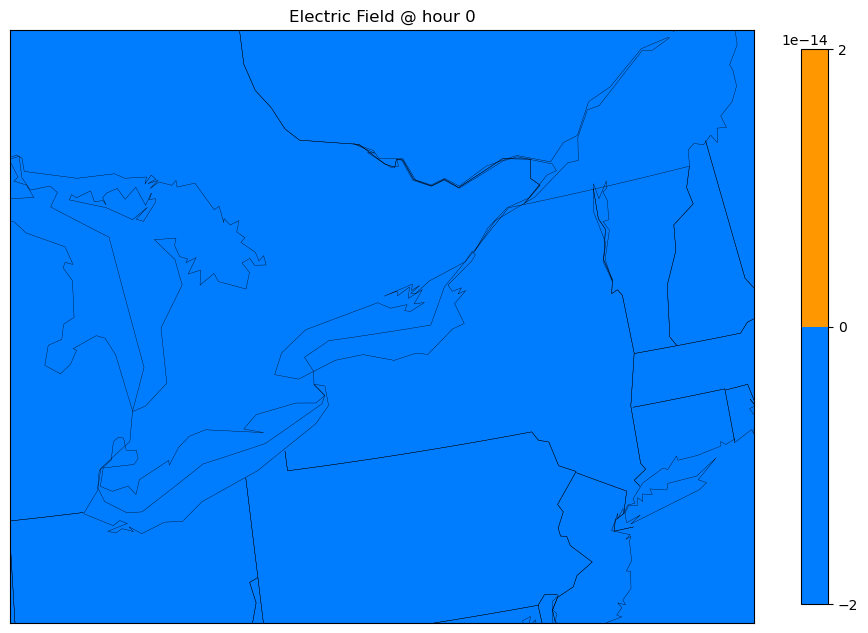

In [5]:
def animate(i):
    # Clear the axis for a new plot frame
    ax.clear()
    
    # Add geographic outlines
    bm.drawcoastlines(linewidth=0.25)
    bm.drawstates(linewidth=0.25)
    bm.drawcountries(linewidth=0.25)

    # Set x and y limits
    x_min, x_max = ax.get_xlim()
    y_min, y_max = ax.get_ylim()
    ax.set_xlim(x_min,x_max)
    ax.set_ylim(y_min,y_max)
    
    # Plot the contour data for the current hour
    animdata = bm.contourf(x, y, vargot[i].max(axis=0), 10, cmap=plt.colormaps.get_cmap("jet"))

    # Add a title with the current time step
    plt.title(f"Electric Field @ hour {i}")

    # Update the color bar
    animcolorbar.update_normal
    
    return animdata

# Create a figure
fig, ax = plt.figure(figsize=(12,9)), plt.gca()

# Get the latitude and longitude points
lats, lons = latlon_coords(vargot[0])

# Get the cartopy mapping object
bm = get_basemap(vargot[0])

# Convert the lats and lons to x and y. Make sure you convert the lats and lons to numpy arrays via to_np,
# or basemap crashes with an undefined RuntimeError.
x, y = bm(to_np(lons), to_np(lats))

#Create initial plot
initdata = bm.contourf(x, y, vargot[0].max(axis=0), 10, cmap=plt.colormaps.get_cmap("jet"))

#Create color bar
animcolorbar = fig.colorbar(initdata, ax=ax, shrink=0.8)

# Warning for jupyterlab users
print("GIF will not appear below (at least using jupyter notebook) but will save to your current folder as IOP#.gif")

# Animate and save gif
anim = animation.FuncAnimation(fig, animate, frames=totalhours, interval = 1000)
anim.save(f"IOP{iop}.gif")

## Maximum Value Finder
#### Locates the grid point with the maximum value of your specified variable

In [6]:
# Get the hour that the user wants the maximum value from
maxvalhour = int(input("Enter your wanted run hour: "))

# Find the maximum value and its index
max_value = np.max(vargot[maxvalhour])
#max_index = np.argmax(vargot[maxvalhour]) # WHY IS THIS NOT WORKING????????

# Filler terrible for loop because I can't get np.argmax to work (apologies for this abomination)
temparray = vargot[maxvalhour]
shape = temparray.shape
for i in range(shape[0]):
    for j in range(shape[1]):
        for k in range(shape[2]):
            value = temparray[i, j, k]
            if value == max_value:
                max_x = j
                max_y = k
                break
        if value == max_value:
            break
    if value == max_value:
        break 

# Change the given x and y values into latitudes and longitudes 
max_lat, max_long = wrf.xy_to_ll(wrfin[maxvalhour], max_x, max_y)

# Print results
print("Maximum value:", max_value)
print("Latitude:", max_lat)
print("Longitude:", max_long)

Enter your wanted run hour:  11


Maximum value: <xarray.DataArray 'ELECZ' ()> Size: 4B
array(2906.7703, dtype=float32)
Coordinates:
    XTIME    float32 4B 660.0
    Time     datetime64[ns] 8B 2022-11-18T11:00:00
Latitude: <xarray.DataArray 'latlon' ()> Size: 8B
array(46.0445862)
Coordinates:
    xy_coord  object 8B CoordPair(x=119, y=167)
    lat_lon   <U3 12B 'lat'
Longitude: <xarray.DataArray 'latlon' ()> Size: 8B
array(-77.92513363)
Coordinates:
    xy_coord  object 8B CoordPair(x=119, y=167)
    lat_lon   <U3 12B 'lon'


## Single Frame
#### Generates a single image for a certain run hour of the entire domain, top down view

Which wrfout hour would you like to visualize?  11


Text(0.5, 1.0, 'Electric Field @ hour 11')

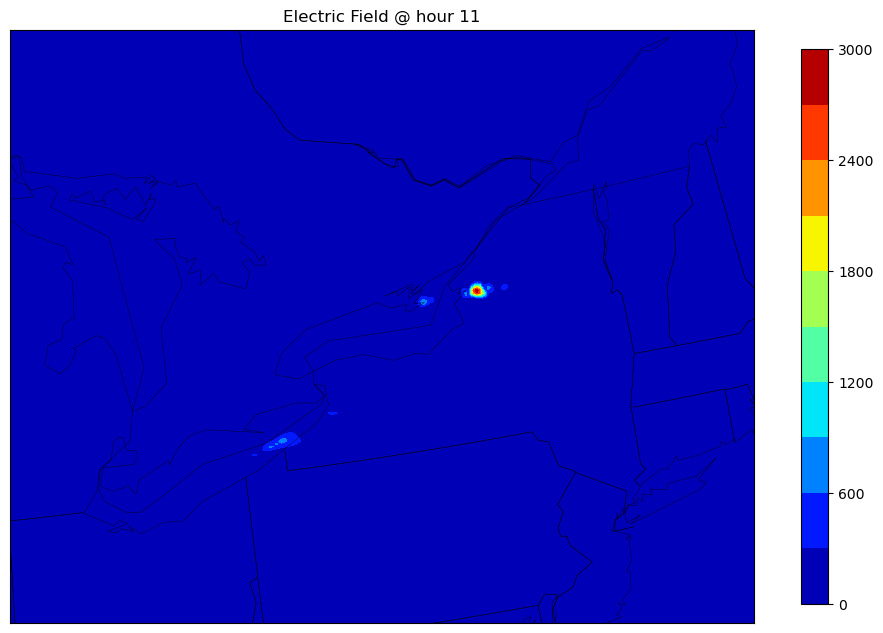

In [7]:
spechour = int(input("Which wrfout hour would you like to visualize? "))

# Get the latitude and longitude points
lats, lons = latlon_coords(vargot[0])

# Get the cartopy mapping object
bm = get_basemap(vargot[0])

# Create a figure
fig = plt.figure(figsize=(12,9))

# Add geographic outlines
bm.drawcoastlines(linewidth=0.25)
bm.drawstates(linewidth=0.25)
bm.drawcountries(linewidth=0.25)

# Convert the lats and lons to x and y. Make sure you convert the lats and lons to numpy arrays via to_np,
# or basemap crashes with an undefined RuntimeError.
x, y = bm(to_np(lons), to_np(lats))

# Set x and y limits
ax = plt.gca()
x_min, x_max = ax.get_xlim()
y_min, y_max = ax.get_ylim()
ax.set_xlim(x_min,x_max)
ax.set_ylim(y_min,y_max)

# Plot filled countours and add a colorbar
staticdata = bm.contourf(x, y, vargot[spechour].max(axis=0), 10, cmap=plt.colormaps.get_cmap("jet"))
fig.colorbar(staticdata, ax=ax, shrink=0.8)
plt.title(f"Electric Field @ hour {spechour}")

## 2-D Vertical Profile
#### Generates a 2-D vertical profile across a specified plane

## Single Point Vertical Profile
#### Generates a non-skewed vertical profile of a single point

Enter your wanted run hour:  11
Enter your wanted latitude:  46.044
Enter your wanted longitude:  -77.925


Text(0.5, 0, 'ELECZ')

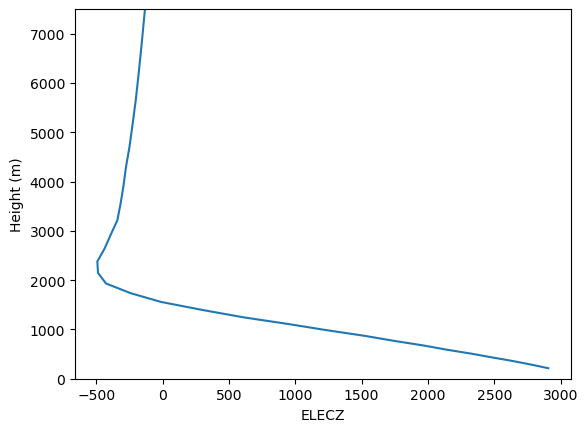

In [10]:
# Get user inputs needed for vertical profile
vertpointhour = int(input("Enter your wanted run hour: "))
lat_point = float(input("Enter your wanted latitude: "))
lon_point = float(input("Enter your wanted longitude: "))

# Change latitude and longitude into x and y coordinates
x_index, y_index = wrf.ll_to_xy(wrfin[vertpointhour], lat_point, lon_point)

# Get the height and the user specified variable
z = wrf.getvar(wrfin[vertpointhour], "z", timeidx=0)[:, x_index, y_index]
vertpointvar = wrf.getvar(wrfin[vertpointhour], f"{varneeded}", timeidx=0)[:, x_index, y_index]

# Plot the vertical profile
fig = plt.figure()
plt.plot(vertpointvar,z)

# Add relevant limits & labels
ax = plt.gca()
ax.set_ylim([0, 7500])
ax.set_ylabel("Height (m)")
ax.set_xlabel(f"{varneeded}")

## Skew-T Generator
#### Generates a Skew-T of a single point

Enter your wanted run hour:  11
Enter your wanted latitude:  46.044
Enter your wanted longitude:  -77.925


Text(0, 0.5, 'Pressure (hPa)')

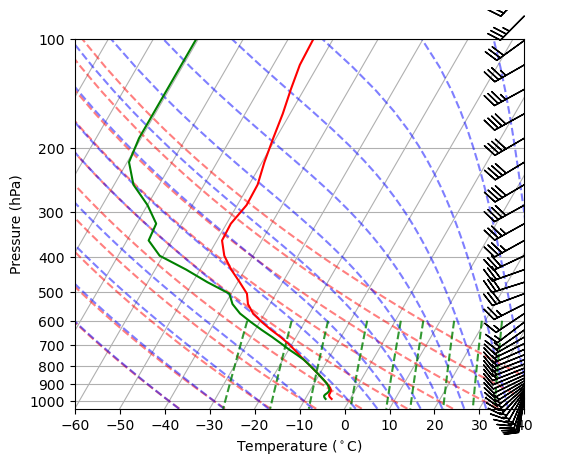

In [11]:
# Get user inputs needed for Skew-T
skewthour = int(input("Enter your wanted run hour: "))
lat_point = float(input("Enter your wanted latitude: "))
lon_point = float(input("Enter your wanted longitude: "))

# Change latitude and longitude into x and y coordinates
x_index, y_index = wrf.ll_to_xy(wrfin[skewthour], lat_point, lon_point)

# Get the needed variables for the Skew-T
p = wrf.getvar(wrfin[skewthour], "pressure", timeidx=0)[:, x_index, y_index] * units.hPa
T = wrf.getvar(wrfin[skewthour], "tc", timeidx=0)[:, x_index, y_index] * units.degC
Td = wrf.getvar(wrfin[skewthour], "td", timeidx=0)[:, x_index, y_index] * units.degC
u = wrf.getvar(wrfin[skewthour], "ua", timeidx=0)[:, x_index, y_index] * units('m/s')
v = wrf.getvar(wrfin[skewthour], "va", timeidx=0)[:, x_index, y_index] * units('m/s')

# Plot the Skew-T
skew = SkewT()
skew.plot(p, T, 'r')
skew.plot(p, Td, 'g')
skew.plot_barbs(p, u, v)

# Add relevant lines, limits, & labels
skew.plot_dry_adiabats()
skew.plot_moist_adiabats()
skew.plot_mixing_lines()
skew.ax.set_xlim(-60, 40)
skew.ax.set_xlabel('Temperature ($^\circ$C)')
skew.ax.set_ylabel('Pressure (hPa)')